In [1]:
import random
import sys
sys.path.append('src/')
sys.path.append('experiments/')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error
from sklearn.model_selection import train_test_split

from src.clause_generator import ClauseGenerator
from src.ilp_solver import ILPSolver
from src.ilp_problem import ILPProblem
from src.data_utils import DataUtils
from src.visualize import Visualize
from experiments.parameters import get_parameters
from experiments.eval_utils import get_dataset_with_noise, compute_auc, compute_mse, extract

In [2]:
### problem
problem = 'basic_causal'
# problem = 'delete'
#problem = 'plus'
#problem = 'append'
#problem = 'subtree'

### noise_rate
noise_rate = 0

In [3]:
test_size = 0.3
du = DataUtils(problem)
pos, neg, bk, clauses, lang = du.load_data()
pos_train, pos_test = train_test_split(
    pos, test_size=test_size, random_state=7014)
neg_train, neg_test = train_test_split(
    neg, test_size=test_size, random_state=7014)

# N_beam, T_beam, T, m = get_parameters(problem)

### add noise
pos_train_, neg_train_ = get_dataset_with_noise(pos_train, neg_train, noise_rate=noise_rate)
ilp_train = ILPProblem(pos_train_, neg_train_, bk, lang, name=problem)
ilp_train.print()

======= POSITIVE EXAMPLES =======
[effect(a,time(c,2)), effect(b,time(a,2)), effect(a,time(c,1)), effect(c,time(c,2)), effect(a,time(b,1))]
======= NEGATIVE EXAMPLES =======
[effect(b,time(b,1)), effect(c,time(a,2)), effect(c,time(c,0)), effect(a,time(b,0))]
======= BACKGROUND KNOWLEDGE  =======
[cause(a,time(b,0)), cause(a,time(c,0)), cause(b,time(a,0)), cause(c,time(c,0)), after(0,1), after(0,2)]


In [4]:
N_beam, T_beam, T, m = (10, 5, 4, 2)

In [5]:
CG = ClauseGenerator(ilp_train, infer_step=T, max_depth=1, max_body_len=3)
solver = ILPSolver(ilp_train, C_0=clauses, CG=CG, m=m, infer_step=T)

In [6]:
N_max = 50 # maximum number of clauses
lr = 1e-2
epoch = 2000

### train weights
clauses, Ws, loss_list = solver.train(
        gen_mode='beam', N_max=N_max, T_beam=T_beam, N_beam=N_beam, epoch=epoch, lr=lr, wd=0.0)

Generating clauses...


/home/dbavikad/leibniz/cilp/cilp-grid/cdilp-st/src/clause_generator.py:238: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  probs = torch.tensor([valuation[facts.index(p)]


======= BEAM SEARCHED CLAUSES ======
effect(X,time(X,X)):-.
effect(X,time(X,X)):-after(X,X).
effect(X,time(X,X)):-cause(X,X),after(X,X).
effect(X,time(X,X)):-cause(X,X),cause(X,X).
effect(X,time(X,X)):-cause(X,X),effect(X,X).
effect(X,time(X,X)):-cause(X,X).
effect(X,time(X,X)):-effect(X,X).
effect(X,time(X,Y)):-.
effect(X,time(X,Y)):-after(X,X).
effect(X,time(X,Y)):-after(X,Y).
effect(X,time(X,Y)):-after(Y,X).
effect(X,time(X,Y)):-cause(X,X).
effect(X,time(X,Y)):-cause(X,Y),after(Y,X).
effect(X,time(X,Y)):-cause(X,Y),cause(Y,X).
effect(X,time(X,Y)):-cause(X,Y).
effect(X,time(X,Y)):-cause(Y,X),after(X,Y).
effect(X,time(X,Y)):-cause(Y,X),after(Y,X),cause(X,Y).
effect(X,time(X,Y)):-cause(Y,X),after(Y,X),effect(X,Y).
effect(X,time(X,Y)):-cause(Y,X),after(Y,X),effect(Y,X).
effect(X,time(X,Y)):-cause(Y,X),after(Y,X).
effect(X,time(X,Y)):-cause(Y,X),cause(X,Y).
effect(X,time(X,Y)):-cause(Y,X),effect(X,Y).
effect(X,time(X,Y)):-cause(Y,X),effect(Y,X),after(X,Y).
effect(X,time(X,Y)):-cause(Y,X)

  1%|          | 20/2000 [00:00<00:20, 95.32it/s, loss=0.915]

100%|██████████| 2000/2000 [00:21<00:00, 92.99it/s, loss=0.973]

====== LEARNED PROGRAM ======
C_0:  effect(X,time(Y,Z)):-. 0.31056278944015503
C_1:  effect(X,time(X,Y)):-cause(Y,X). 0.03669971227645874


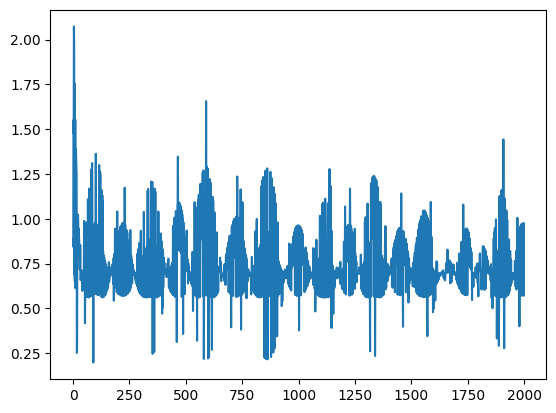

In [7]:
### plot training loss
%matplotlib inline
plt.plot(loss_list)
plt.show()

In [8]:
### evaluate on test data
v_list, facts = solver.predict(pos_test, neg_test, clauses, Ws)
mse = compute_mse(pos_test, neg_test, v_list, facts)
auc = compute_auc(pos_test, neg_test, v_list, facts)

print('====== TEST SCORE =======')
print('Mean-squared test error: ', mse)
print('AUC: ', auc)

Enumerating facts...
Building tensors...
====== TEST SCORE =======
Mean-squared test error:  0.32376448386915885
AUC:  0.41666666666666663


Enumerating facts...
Building tensors...


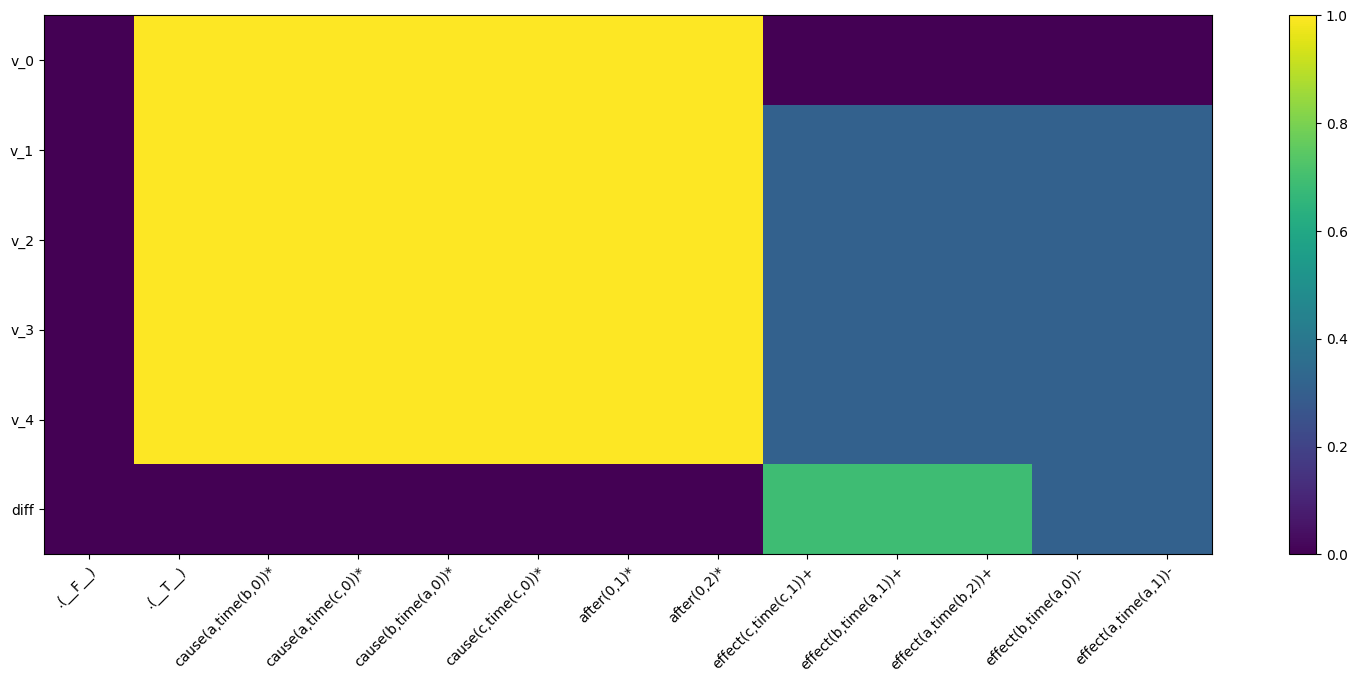

In [9]:
# Visualize v_0, v_1, ..., v_n after learning

v_list, facts = solver.get_valuation_memory(pos_test, neg_test, clauses, Ws)
ilp_test = ILPProblem(pos_test, neg_test, bk, lang, name=problem)
vis = Visualize(ilp_test, name=problem, facts=facts)
vis.plot_valuation_memory(v_list)